<a href="https://colab.research.google.com/github/shk0349/AI_Study_24/blob/master/%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9D_%EA%B7%B8%EB%A6%AC%EB%93%9C%EC%84%9C%EC%B9%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

지금까지 배운 알고리즘은 훈련세트와 테스트세트를 나우어 평가를 진행중이나,

결국 테스트세트로 평가 진행 시 테스트세트에 맞는 모델이 만들어짐

테스트 세트에 일반화 성능을 올바르게 예측하려면 가능한 테스트세트를 사용하지 않아야하며, 모델을 만들고나서 마지막에 딱 한번 사용하는 것이 좋음

결정트리에서 max_depth 매개변수를 사용한 하이퍼파라미터 튜닝 실시

In [28]:
# 검증세트
# 테스트세트를 사용하지 않으려면 모델이 과대적합인지 과소접합인지 판단하기 어려움
# 테스트세트를 사용하지 않고, 측정하는 간단한 방법은 훈련세트를 또 나누면 됨
# 훈련세트 60%, 검증세트 20%, 테스트세트 20%로 분할 구성 -> 실무에서 주로 사용하는 기법

# 테스트하고 싶은 매개변수를 바꿔가면서 가장 좋은 모델이 나올 수 있음
# 이 매개변수를 사용하여 훈련세트와 검증세트를 합쳐 전체 훈련 데이터에서 모델을 다시 훈련함
# 마지막 테스트에서 최종점수 평가
# 훈련세트에서 모델 훈련 후 검증세트로 모델 평가
# 마지막 세트에서 테스트세트를 이용 최종점수 평가

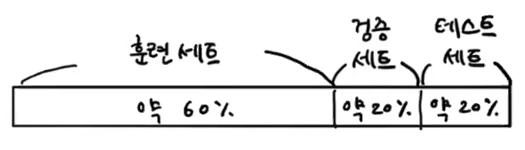

In [29]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')

data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

from sklearn.model_selection import train_test_split
# 데이터와 타겟을 훈련세트(80%)와 테스트세트(20%)로 분할
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size = 0.2, random_state = 42)
# 훈련세트를 훈련세트(64%)와 검증세트(16%)로 분할
sub_input, val_input, sub_target, val_target = train_test_split(train_input, train_target, test_size = 0.2, random_state = 42)
print(sub_input.shape, val_input.shape, test_input.shape)

(4157, 3) (1040, 3) (1300, 3)


In [30]:
# sub_input, sub_target과 val_input, val_target을 사용하여 모델을 만들고 평가
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 42)
dt.fit(sub_input, sub_target)

print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))
# 훈련세트(99.71%) > 검증세트(86.44%) 이나 훈련세트가 지나치게 높아 과대적합이므로 매개변수를 바꾸어 더 좋은 모델을 찾아야함

0.9971133028626413
0.864423076923077


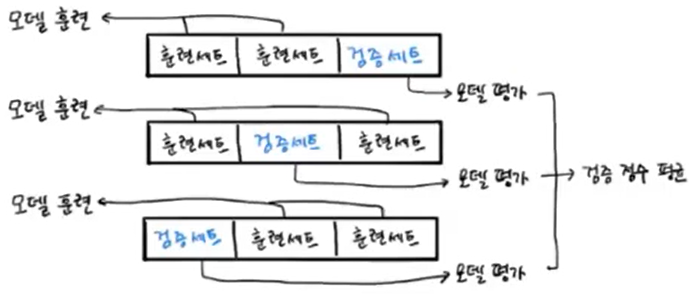

In [31]:
# 검증세트 생성을 위해 훈련세트가 감소함(많은 데이터를 훈련하면 좋은 결과가 도출됨)
# 교차검증 : 검증 세트를 떼어내어 평가하는 과정을 여러번 반복
# [훈련세트, 훈련세트, 검증세트]
# [훈련세트, 검증세트, 훈련세트]
# [검증세트, 훈련세트, 훈련세트] -> 패리티 방식(3-폴드 교차 검증 / 5-폴드, 10-폴드도 있음)
# 사이킷런의 cross_validate()라는 교차검증 함수를 이용

In [32]:
from sklearn.model_selection import cross_validate
# 평가할 모델 객체를 첫번째 매개변수로 전달(직접 검증세트를 분할하지 않고 훈련세트 전체를 전달)
scores = cross_validate(dt, train_input, train_target)
# scores = cross_validate(dt, train_input, train_target, cv = 5)
# cv 매개변수를 이용하여 폴드 수를 변경(cv의 default값 : 5)
print(scores)    # fit_time : 훈련시간 / score_time : 검증시간 / test_score : 최종점수 / 키를 가진 딕셔너리(k : v)를 반환함

{'fit_time': array([0.0106771 , 0.01345658, 0.01727223, 0.01355314, 0.01113081]), 'score_time': array([0.00201082, 0.00229359, 0.00221395, 0.00230265, 0.00143266]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


In [33]:
# {'fit_time': array([0.0171473 , 0.01191282, 0.01234317, 0.01222873, 0.01243949]),
# 'score_time': array([0.00213981, 0.00207138, 0.00197196, 0.00174952, 0.00177789]),
# 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}

In [34]:
import numpy as np

print(np.mean(scores['test_score']))    # 검증점수의 평균

0.855300214703487


In [35]:
# 주의사항 : cross_validate()는 훈련세트를 섞어서 폴드를 분할하지 않음 -> 분할기 사용(splitter)
# train_test_split() 함수로 전체 데이터를 섞은 후 훈련세트를 준비했으나, 만약 교차 검증을 할 때 훈련세트를 섞으려면 분할기(splitter)를 지정해야함

# 사이킷런의 분할기는 교차검증에서 폴드를 어떻게 나눌지 결정
# cross_validate()는 기본적으로 회귀모델인 KFold 분할기 사용
# 분류 모델일 경우 target class를 골고루 나누기 위하여 StratifiedKFold 사용

from sklearn.model_selection import StratifiedKFold

scores = cross_validate(dt, train_input, train_target, cv = StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


In [36]:
splitter = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)    # 10-폴드 교차 검증 수행
scores = cross_validate(dt, train_input, train_target, cv = splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


In [37]:
# 결정트리의 매개변수 값을 바꿔가며 가장 좋은 성능이 나오는 모델을 찾아봐야 함
# 테스트 세트를 사용하지 않고 교차 검증을 통해서 좋은 모델을 골라야함

# 하이퍼파라미터 튜닝
# 모델 파라미터 : 머신러닝 모델이 학습하는 파라미터
# 하이퍼파라미터 : 사용자가 지정해야만 하는 파라미터
# 하이퍼파라미터 튜닝 : 라이브러리가 제공하는 기본값을 그대로 사용해 모델을 훈련
# 그 다음 검증세트의 점수나 교차 검증을 통해서 매개변수를 조금씩 변경 1 ~ 2, 5 ~ 6개의 매개변수를 제공
# AutoML : 사람의 개입없이 하이퍼파라미터 튜닝을 자동으로 수행하는 기술

# Max_depth를 최적으로 고정하고 min_sample_split을 바꿔가며 최적의 값을 찾는다. 면 값이 함께 변경됨
# -> 두개의 매개변수를 동시에 바꿔가며 최적의 값을 찾아야 함 -> 복잡해짐
# 사이킷런에서 제공하는 그리드 서치(Grid Search)가 제공 GridSearchCV

In [43]:
from sklearn.model_selection import GridSearchCV
# min_impurity_decrease 매개변수의 최적값 확인
# min_sample_split : 샘플을 최소한 몇개 이상이어야 split(하위노드로 분리) / 과대적합 방지를 위해 클수록 가지치기, 작을수록 정확하기
params = {'min_impurity_decrease' : [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}    # 0.0001 ~ 0.0005까지 0.0001 단위로 증가
# 매겨변수와 탐색할 값의 리스트를 딕셔너리로 생성

gs = GridSearchCV(DecisionTreeClassifier(random_state = 42), params, n_jobs = -1)
# 결정트리 클래스의 객체를 생성하지마나 바로 전달
# 일반 모델을 훈련하는 것처럼 .fit() 매서드를 호출
# 이 매서드를 호출하면 서치 객체는 결정트리모델 min_impurity_decrease 값을 바꿔가면서 총 5번 수행
# GridSearchCV의 cv 매개변수 기본값은 5 -> 5 * 5 = 25번 수행
# n_jobs에서 병렬 시행에 사용될 CPU 코어수를 지정함 / -1 : 모든 코어 사용

gs.fit(train_input, train_target)
# 교차 검증에서 최적의 하이퍼파라미터를 찾으면 전체 훈련 세트로 모델을 다시 만들어야 하나,
# 사이킷런의 그리드 서치는 검증 점수가 가장 높은 모델의 매개변수 조합으로 전체 훈련 세트에서 자동으로 다시 모델을 훈련함

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

In [44]:
# 이와 같이 최적화되어 훈련된 모델은 GridSearchCV 클래스로 만들어진 객체의 best_estimator_ 속성에, 최적의 매개변수는 best_params_ 속성에 저장되어 있음
print(f"그리드 서치를 통해 찾은 최적의 모델 정확도 : {dt.score(train_input, train_target) * 100 : .2f}%")
print(f"최적의 매개변수 : {gs.best_params_}")
# 각 매개변수에서 수행한 교차검증의 평균점수는 cv_results_ 속성의 'mean_test_score'키에 저장되어 있음

그리드 서치를 통해 찾은 최적의 모델 정확도 :  97.06%
최적의 매개변수 : {'min_impurity_decrease': 0.0001}


In [45]:
# 5번의 교차검증으로 얻은 점수를 출력
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [48]:
# 눈으로 보는 것 보다 numpy의 argmax() 함수를 사용하면 가장 큰 값의 인덱스 추출 가능
# 해당 인덱스를 이용하여 params 키에 저장된 매개변수 출력
# 이 값이 최상의 검증 점수를 만든 매개변수의 조합임
best_index = np.argmax(gs.cv_results_['mean_test_score'])    # 0.86819297
print(gs.cv_results_['params'][best_index])    # 앞에서 출력한 best_params 와 같은지 확인

# 과정 요약
# 1. 탐색할 매개변수 지정
# 2. 훈련 세트에서 그리드 서치를 수행하여 최상의 평규점수가 나오는 매개변수 조합을 찾음 -> 그리드 서치에 저장
# 3. 그리드 서치는 최상의 매개변수에서 전체 훈련 세트를 사용해 최종모델 훈련 -> 그리드 서치에 저장

{'min_impurity_decrease': 0.0001}


In [51]:
# 조금 더 복잡 한 매개변수 조합 시행
# 노드를 분할하기 위한 불순도 감소 최소량 지정 max_depth(트리의 깊이)
# min_samples_split : 노드를 나누기 위한 최소 샘플 수
# numpy의 arange() 함수는 첫번째 매개변수 값에서 시작하여 두번째 매개변수에 도달할 때 까지 세번쨰 매개변수를 계속 더한 배열 생성
params = {'min_impurity_decrease' : np.arange(0.0001, 0.001, 0.0001),     # 0.0001 ~ 0.001까지 0.0001씩 더한 배열(두번째 매개변수는 포함되지 않음) / 9회
          'max_depth' : range(5, 20, 1),     # 파이선 range() 함수는 정수만 사용 가능(5 ~ 20까지 1씩 증가 / 15회)
          'min_samples_split' : range(2, 100, 10)}    # 2 ~ 100까지 10씩 증가 / 10회
# 교차 검증 횟수 : 9 * 15 * 10 = 1350개 * 5(5-폴드교차) = 6750개

# criterion : 분할 품질을 측정한느 기능 (default : gini)
# splitter : 각 노드에서 분할을 선택하는데 사용되는 전략 (default : best)
# max_depth : 트리의 최대 깊이(값이 클수록 모델의 복잡도 상승)
# min_samples_split : 자식 노드를 분할하는데 필요한 최소 샘플의 수 (default : 2)
# min_samples_leaf : 리프 노드에 있어야 할 최소 샘플 수 (default : 1)
# min_weight_fraction_leaf : min_samples_leaf와 같지만 가중치가 부여된 샘플 수에서의 비율
# max_features : 각 노드에서 분할에 사용할 특징의 최대 수
# random_state : 난수 seed 설정
# max_leaf_nodes : 리프 노드의 최대 수
# min_impurity_decrease : 최소 불순도
# min_impurity_split : 나무 성장을 멈추기 위한 임계치
# class_weight : 클래스 가중치
# presort : 데이터 정렬 필요 여부

gs = GridSearchCV(DecisionTreeClassifier(random_state = 42), params, n_jobs = -1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [53]:
print(gs.best_params_)    # 최상의 매개변수 조합 확인

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [55]:
print(np.max(gs.cv_results_['mean_test_score']))    # 최상의 교차 점수 확인
# 개선점 : 탐색할 매개변수 간격을 0.0001 or 1로 설정하였으나, 근거가 부족함(좁히거나 넓힐 필요성)

0.8683865773302731


In [56]:
# 매개변수의 값이 수치일 때 값의 범위나 간격을 미리 정하기 어려울 수 있음
# 너무 많은 매개변수 조건이 있어 그리드 서치 수행시간이 오래걸림 -> 랜덤 서치 사용하여 해결 가능

# 랜덤서치 : 매개변수 값의 목록을 전달하는 것이 아니라 매개변수의 샘플링할 수 있는 확률 분포도 객체 전달
# 싸이파이 : python의 핵심 과학 라이브러리로 적분, 보간, 선형대수, 확률 등을 포함한 수치 계산용 전용 라이브러리(코랩에 내장)

from scipy.stats import uniform, randint
# uniform, randint 클래스는 모두 주어진 범위에서 고르게 값을 뽑음(균등 분포에서 샘플링)
# randint()에서는 정수값을 추출, uniform()은 실수값 출력

In [58]:
rgen = randint(0, 10)    # 10개 숫자를 샘플링(랜덤확률)
rgen.rvs(10)
# 10개 밖에 되지 않기 때문에 고르게 샘플링되는 것 같지 않지만 샘플링 숫자를 확대하면 쉽게 확인가능

array([1, 8, 5, 6, 3, 2, 2, 6, 0, 9])

In [61]:
np.unique(rgen.rvs(1000), return_counts = True)    # 1000개를 샘플링하여 각 숫자의 갯수를 count

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([105, 105, 104,  92, 104,  98, 112,  96,  93,  91]))

In [63]:
ugen = uniform(0, 1)    # 실수 샘플링(랜덤확률)
ugen.rvs(10)    # 난수 발생기(랜덤과 유사)

array([0.35406779, 0.2030789 , 0.58695994, 0.50910929, 0.57405184,
       0.50042604, 0.84107321, 0.61212924, 0.22569012, 0.49403208])

In [64]:
# 탐색할 매개변수의 딕셔너리 생성
# min_samples_leaf를 탐색 대상에 추가
params = {'min_impurity_decrease' : uniform(0.0001, 0.001),    # 0.0001 ~ 0.001의 실수값
          'max_depth' : randint(20, 50),    # 20 ~ 50사이의 정수
          'min_samples_split' : randint(2, 25),    # 2 ~ 25 사이의 정수
          'min_samples_leaf' : randint(1, 25)}    # 1 ~ 25 사이의 정수
# 리프노드가 되기 위한 최소 샘플 개수 (자식 노드의 샘플 수보다 이 값이 작으면 분할되지 않음)

In [65]:
# 샘플링 횟수는 사이킷런의 랜덤서치클래스인 RandomizedSearchCV의 n_iter 매개변수에 지정
from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(DecisionTreeClassifier(random_state = 42), params, n_iter = 100, n_jobs = -1, random_state = 42)
# n_iter = 100 : 총 100번 샘플링하여 교차 검증 수행(최적의 매개변수 조합을 찾음)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7befea163910>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7befea1f86a0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7befea163f10>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7befea1f8e20>},
                   random_state=42)

In [66]:
print(gs.best_params_)    # 결과 : 최적의 매개변수 조합을 찾음

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [67]:
print(np.max(gs.cv_results_['mean_test_score']))    # 최고의 교차 검증 점수 확인

0.8695428296438884


In [69]:
dt = gs.best_estimator_
# 최종 모델로 결정하여 테스트세트 성능 확인
print(dt.score(test_input, test_target))
# 검증점수(86.95%) > 테스트점수(86.0%)로 과대 및 과소적합에 미해당되어 적합한 값이다.

0.86
